In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo

import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.0 MB/s eta 0:00:00
Using device: cuda


In [6]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)


In [7]:
from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_44c"
DATASET = "fernando2rad/brain-tumor-mri-images-44c"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)

print("Dataset downloaded to:", DATA_DIR)


Dataset downloaded to: brain_tumor_44c


In [8]:
from pathlib import Path

IMAGE_EXTS = (".jpg", ".jpeg", ".png")

paths, labels = [], []

# Collect class folders
class_dirs = []
for root, dirs, files in os.walk(DATA_DIR):
    if any(f.lower().endswith(IMAGE_EXTS) for f in files):
        class_dirs.append(root)

class_dirs = sorted(class_dirs)

class_to_idx = {Path(d).name: idx for idx, d in enumerate(class_dirs)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Number of classes:", len(class_to_idx))

for root, _, files in os.walk(DATA_DIR):
    class_name = Path(root).name
    if class_name not in class_to_idx:
        continue

    label = class_to_idx[class_name]

    for f in files:
        if f.lower().endswith(IMAGE_EXTS):
            paths.append(os.path.join(root, f))
            labels.append(label)

df = pd.DataFrame({
    "image_path": paths,
    "label": labels
})

print("Total images:", len(df))
print("Class distribution:\n", df["label"].value_counts().sort_index())

num_classes = df["label"].nunique()


Number of classes: 44
Total images: 4478
Class distribution:
 label
0     176
1     232
2     171
3      66
4     112
5      73
6      45
7      48
8      57
9      20
10     18
11     23
12     27
13     40
14     33
15     55
16     94
17     55
18     30
19     31
20     17
21     23
22     67
23     41
24    272
25    369
26    233
27    130
28    223
29    104
30     86
31     72
32     66
33     66
34    108
35     63
36    148
37    194
38    123
39     28
40     84
41     33
42    251
43    271
Name: count, dtype: int64


In [9]:
train_df, test_df = train_test_split(
    df, stratify=df.label, test_size=0.2, random_state=42
)

train_df, val_df = train_test_split(
    train_df, stratify=train_df.label, test_size=0.2, random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 2865
Val: 717
Test: 896


In [10]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label


In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


In [12]:
train_loader = DataLoader(
    BrainTumorDataset(train_df, transform),
    batch_size=16,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    BrainTumorDataset(val_df, transform),
    batch_size=16,
    num_workers=2
)

test_loader = DataLoader(
    BrainTumorDataset(test_df, transform),
    batch_size=16,
    num_workers=2
)


In [13]:
model = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)

summary(model, input_size=(1,3,224,224))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 44]                   152,064
├─PatchEmbed: 1-1                        [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          590,592
│    └─Identity: 2-2                     [1, 196, 768]             --
├─Dropout: 1-2                           [1, 197, 768]             --
├─Identity: 1-3                          [1, 197, 768]             --
├─Identity: 1-4                          [1, 197, 768]             --
├─Sequential: 1-5                        [1, 197, 768]             --
│    └─Block: 2-3                        [1, 197, 768]             --
│    │    └─LayerNorm: 3-1               [1, 197, 768]             1,536
│    │    └─Attention: 3-2               [1, 197, 768]             2,362,368
│    │    └─Identity: 3-3                [1, 197, 768]             --
│    │    └─Identity: 3-4                [1, 197, 768]           

In [14]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4
)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


In [15]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [22]:
from PIL import Image


In [23]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader, desc=f"Training - Epoch [{epoch+1}/{EPOCHS}]")

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = out.argmax(1)

        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(train_targets, train_preds)
    train_out = {k: v.compute().item() for k, v in train_metrics.items()}

    print(f"\n===== Epoch {epoch+1} TRAIN =====")
    print(f"Loss: {train_loss:.4f}")
    print(f"Acc: {train_out['acc']:.4f} | Prec: {train_out['precision']:.4f} | "
          f"Recall: {train_out['recall']:.4f} | F1: {train_out['f1']:.4f}")
    print(f"Spec: {train_spec:.4f} | Sens: {train_sens:.4f} | "
          f"MCC: {train_out['mcc']:.4f} | AUC: {train_out['auc']:.4f}")

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validating"):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()

            preds = out.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out, y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(val_targets, val_preds)
    val_out = {k: v.compute().item() for k, v in val_metrics.items()}

    print(f"\n===== Epoch {epoch+1} VALID =====")
    print(f"Loss: {val_loss:.4f}")
    print(f"Acc: {val_out['acc']:.4f} | Prec: {val_out['precision']:.4f} | "
          f"Recall: {val_out['recall']:.4f} | F1: {val_out['f1']:.4f}")
    print(f"Spec: {val_spec:.4f} | Sens: {val_sens:.4f} | "
          f"MCC: {val_out['mcc']:.4f} | AUC: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    scheduler.step()

    # ================= SAVE HISTORY =================
    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(train_out["acc"])
    history["val_accuracy"].append(val_out["acc"])
    history["precision"].append(train_out["precision"])
    history["val_precision"].append(val_out["precision"])
    history["recall"].append(train_out["recall"])
    history["val_recall"].append(val_out["recall"])
    history["f1"].append(train_out["f1"])
    history["val_f1"].append(val_out["f1"])
    history["specificity"].append(train_spec)
    history["val_specificity"].append(val_spec)
    history["sensitivity"].append(train_sens)
    history["val_sensitivity"].append(val_sens)
    history["mcc"].append(train_out["mcc"])
    history["val_mcc"].append(val_out["mcc"])
    history["auc"].append(train_out["auc"])
    history["val_auc"].append(val_out["auc"])

    # ================= EARLY STOPPING =================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_vit_44c.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training - Epoch [1/30]: 100%|██████████| 180/180 [01:35<00:00,  1.89it/s]



===== Epoch 1 TRAIN =====
Loss: 3.4235
Acc: 0.0511 | Prec: 0.0540 | Recall: 0.0511 | F1: 0.0454
Spec: 0.9785 | Sens: 0.0511 | MCC: 0.0554 | AUC: 0.6347


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.77it/s]



===== Epoch 1 VALID =====
Loss: 3.2193
Acc: 0.0727 | Prec: 0.0408 | Recall: 0.0727 | F1: 0.0438
Spec: 0.9795 | Sens: 0.0727 | MCC: 0.1130 | AUC: 0.7469
Current LR: 5.000000e-04



Training - Epoch [2/30]: 100%|██████████| 180/180 [01:42<00:00,  1.76it/s]



===== Epoch 2 TRAIN =====
Loss: 3.0658
Acc: 0.0874 | Prec: 0.0793 | Recall: 0.0874 | F1: 0.0773
Spec: 0.9801 | Sens: 0.0874 | MCC: 0.1248 | AUC: 0.7364


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.88it/s]



===== Epoch 2 VALID =====
Loss: 2.8415
Acc: 0.1340 | Prec: 0.1240 | Recall: 0.1340 | F1: 0.0977
Spec: 0.9815 | Sens: 0.1340 | MCC: 0.1925 | AUC: 0.8291
Current LR: 4.986305e-04



Training - Epoch [3/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 3 TRAIN =====
Loss: 2.8431
Acc: 0.1389 | Prec: 0.1342 | Recall: 0.1389 | F1: 0.1284
Spec: 0.9816 | Sens: 0.1389 | MCC: 0.1901 | AUC: 0.7862


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.79it/s]



===== Epoch 3 VALID =====
Loss: 2.8545
Acc: 0.0972 | Prec: 0.1215 | Recall: 0.0972 | F1: 0.0814
Spec: 0.9807 | Sens: 0.0972 | MCC: 0.1608 | AUC: 0.8302
Current LR: 4.945369e-04



Training - Epoch [4/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 4 TRAIN =====
Loss: 2.7936
Acc: 0.1387 | Prec: 0.1278 | Recall: 0.1387 | F1: 0.1293
Spec: 0.9817 | Sens: 0.1387 | MCC: 0.1951 | AUC: 0.7985


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.88it/s]



===== Epoch 4 VALID =====
Loss: 2.9152
Acc: 0.0762 | Prec: 0.0898 | Recall: 0.0762 | F1: 0.0503
Spec: 0.9805 | Sens: 0.0762 | MCC: 0.1510 | AUC: 0.8167
Current LR: 4.877641e-04



Training - Epoch [5/30]: 100%|██████████| 180/180 [01:43<00:00,  1.75it/s]



===== Epoch 5 TRAIN =====
Loss: 2.5623
Acc: 0.1834 | Prec: 0.1768 | Recall: 0.1834 | F1: 0.1732
Spec: 0.9833 | Sens: 0.1834 | MCC: 0.2678 | AUC: 0.8433


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.87it/s]



===== Epoch 5 VALID =====
Loss: 2.6816
Acc: 0.1716 | Prec: 0.1773 | Recall: 0.1716 | F1: 0.1468
Spec: 0.9826 | Sens: 0.1716 | MCC: 0.2383 | AUC: 0.8528
Current LR: 4.783864e-04



Training - Epoch [6/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 6 TRAIN =====
Loss: 2.4231
Acc: 0.2062 | Prec: 0.2309 | Recall: 0.2062 | F1: 0.2010
Spec: 0.9839 | Sens: 0.2062 | MCC: 0.2911 | AUC: 0.8622


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.87it/s]



===== Epoch 6 VALID =====
Loss: 2.5561
Acc: 0.2091 | Prec: 0.2106 | Recall: 0.2091 | F1: 0.1809
Spec: 0.9834 | Sens: 0.2091 | MCC: 0.2741 | AUC: 0.8804
Current LR: 4.665064e-04



Training - Epoch [7/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 7 TRAIN =====
Loss: 2.5960
Acc: 0.1745 | Prec: 0.1944 | Recall: 0.1745 | F1: 0.1690
Spec: 0.9827 | Sens: 0.1745 | MCC: 0.2386 | AUC: 0.8346


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.87it/s]



===== Epoch 7 VALID =====
Loss: 2.5580
Acc: 0.2043 | Prec: 0.2540 | Recall: 0.2043 | F1: 0.1964
Spec: 0.9836 | Sens: 0.2043 | MCC: 0.2880 | AUC: 0.8707
Current LR: 4.522542e-04



Training - Epoch [8/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 8 TRAIN =====
Loss: 2.1997
Acc: 0.2520 | Prec: 0.2842 | Recall: 0.2520 | F1: 0.2493
Spec: 0.9850 | Sens: 0.2520 | MCC: 0.3405 | AUC: 0.8932


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.80it/s]



===== Epoch 8 VALID =====
Loss: 2.4815
Acc: 0.2254 | Prec: 0.2464 | Recall: 0.2254 | F1: 0.2049
Spec: 0.9837 | Sens: 0.2254 | MCC: 0.2897 | AUC: 0.8735
Current LR: 4.357862e-04



Training - Epoch [9/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 9 TRAIN =====
Loss: 2.1345
Acc: 0.2832 | Prec: 0.3092 | Recall: 0.2832 | F1: 0.2832
Spec: 0.9856 | Sens: 0.2832 | MCC: 0.3684 | AUC: 0.9060


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.87it/s]



===== Epoch 9 VALID =====
Loss: 2.3752
Acc: 0.2333 | Prec: 0.2527 | Recall: 0.2333 | F1: 0.2189
Spec: 0.9842 | Sens: 0.2333 | MCC: 0.3086 | AUC: 0.8975
Current LR: 4.172827e-04



Training - Epoch [10/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 10 TRAIN =====
Loss: 2.0406
Acc: 0.3012 | Prec: 0.3253 | Recall: 0.3012 | F1: 0.3035
Spec: 0.9861 | Sens: 0.3012 | MCC: 0.3870 | AUC: 0.9111


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.88it/s]



===== Epoch 10 VALID =====
Loss: 2.3261
Acc: 0.2093 | Prec: 0.3327 | Recall: 0.2093 | F1: 0.2132
Spec: 0.9837 | Sens: 0.2093 | MCC: 0.3034 | AUC: 0.9039
Current LR: 3.969463e-04



Training - Epoch [11/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 11 TRAIN =====
Loss: 1.9381
Acc: 0.3265 | Prec: 0.3817 | Recall: 0.3265 | F1: 0.3357
Spec: 0.9867 | Sens: 0.3265 | MCC: 0.4153 | AUC: 0.9230


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.88it/s]



===== Epoch 11 VALID =====
Loss: 2.1452
Acc: 0.3260 | Prec: 0.3460 | Recall: 0.3260 | F1: 0.3031
Spec: 0.9862 | Sens: 0.3260 | MCC: 0.3976 | AUC: 0.9139
Current LR: 3.750000e-04



Training - Epoch [12/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 12 TRAIN =====
Loss: 1.7815
Acc: 0.3707 | Prec: 0.4239 | Recall: 0.3707 | F1: 0.3810
Spec: 0.9878 | Sens: 0.3707 | MCC: 0.4644 | AUC: 0.9335


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.82it/s]



===== Epoch 12 VALID =====
Loss: 2.1719
Acc: 0.3129 | Prec: 0.3537 | Recall: 0.3129 | F1: 0.2960
Spec: 0.9859 | Sens: 0.3129 | MCC: 0.3834 | AUC: 0.9112
Current LR: 3.516842e-04



Training - Epoch [13/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 13 TRAIN =====
Loss: 1.6104
Acc: 0.4136 | Prec: 0.4675 | Recall: 0.4136 | F1: 0.4236
Spec: 0.9885 | Sens: 0.4136 | MCC: 0.4955 | AUC: 0.9486


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.91it/s]



===== Epoch 13 VALID =====
Loss: 2.0141
Acc: 0.3191 | Prec: 0.4706 | Recall: 0.3191 | F1: 0.3425
Spec: 0.9871 | Sens: 0.3191 | MCC: 0.4398 | AUC: 0.9196
Current LR: 3.272542e-04



Training - Epoch [14/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 14 TRAIN =====
Loss: 1.4504
Acc: 0.4560 | Prec: 0.5253 | Recall: 0.4560 | F1: 0.4704
Spec: 0.9896 | Sens: 0.4560 | MCC: 0.5414 | AUC: 0.9607


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.85it/s]



===== Epoch 14 VALID =====
Loss: 1.9097
Acc: 0.3791 | Prec: 0.4731 | Recall: 0.3791 | F1: 0.3857
Spec: 0.9874 | Sens: 0.3791 | MCC: 0.4510 | AUC: 0.9234
Current LR: 3.019779e-04



Training - Epoch [15/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 15 TRAIN =====
Loss: 1.2925
Acc: 0.5142 | Prec: 0.5709 | Recall: 0.5142 | F1: 0.5288
Spec: 0.9908 | Sens: 0.5142 | MCC: 0.5941 | AUC: 0.9710


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.85it/s]



===== Epoch 15 VALID =====
Loss: 1.8788
Acc: 0.3608 | Prec: 0.4575 | Recall: 0.3608 | F1: 0.3742
Spec: 0.9875 | Sens: 0.3608 | MCC: 0.4544 | AUC: 0.9383
Current LR: 2.761321e-04



Training - Epoch [16/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 16 TRAIN =====
Loss: 1.1837
Acc: 0.5485 | Prec: 0.5951 | Recall: 0.5485 | F1: 0.5651
Spec: 0.9913 | Sens: 0.5485 | MCC: 0.6164 | AUC: 0.9737


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.74it/s]



===== Epoch 16 VALID =====
Loss: 1.7871
Acc: 0.4143 | Prec: 0.4446 | Recall: 0.4143 | F1: 0.4051
Spec: 0.9884 | Sens: 0.4143 | MCC: 0.4925 | AUC: 0.9431
Current LR: 2.500000e-04



Training - Epoch [17/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 17 TRAIN =====
Loss: 0.9307
Acc: 0.6228 | Prec: 0.6680 | Recall: 0.6228 | F1: 0.6387
Spec: 0.9929 | Sens: 0.6228 | MCC: 0.6889 | AUC: 0.9857


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.88it/s]



===== Epoch 17 VALID =====
Loss: 1.9118
Acc: 0.4376 | Prec: 0.5244 | Recall: 0.4376 | F1: 0.4369
Spec: 0.9891 | Sens: 0.4376 | MCC: 0.5227 | AUC: 0.9344
Current LR: 2.238679e-04



Training - Epoch [18/30]: 100%|██████████| 180/180 [01:43<00:00,  1.75it/s]



===== Epoch 18 TRAIN =====
Loss: 0.9019
Acc: 0.6607 | Prec: 0.7049 | Recall: 0.6607 | F1: 0.6776
Spec: 0.9934 | Sens: 0.6607 | MCC: 0.7100 | AUC: 0.9859


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.86it/s]



===== Epoch 18 VALID =====
Loss: 1.8062
Acc: 0.4357 | Prec: 0.4957 | Recall: 0.4357 | F1: 0.4346
Spec: 0.9887 | Sens: 0.4357 | MCC: 0.5015 | AUC: 0.9404
Current LR: 1.980221e-04



Training - Epoch [19/30]: 100%|██████████| 180/180 [01:42<00:00,  1.76it/s]



===== Epoch 19 TRAIN =====
Loss: 0.7294
Acc: 0.7209 | Prec: 0.7537 | Recall: 0.7209 | F1: 0.7331
Spec: 0.9946 | Sens: 0.7209 | MCC: 0.7606 | AUC: 0.9914


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.83it/s]



===== Epoch 19 VALID =====
Loss: 1.9078
Acc: 0.4524 | Prec: 0.5107 | Recall: 0.4524 | F1: 0.4613
Spec: 0.9895 | Sens: 0.4524 | MCC: 0.5395 | AUC: 0.9424
Current LR: 1.727458e-04



Training - Epoch [20/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 20 TRAIN =====
Loss: 0.5439
Acc: 0.7676 | Prec: 0.8128 | Recall: 0.7676 | F1: 0.7850
Spec: 0.9957 | Sens: 0.7676 | MCC: 0.8100 | AUC: 0.9952


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.83it/s]



===== Epoch 20 VALID =====
Loss: 1.8879
Acc: 0.4920 | Prec: 0.5492 | Recall: 0.4920 | F1: 0.5029
Spec: 0.9901 | Sens: 0.4920 | MCC: 0.5645 | AUC: 0.9446
Current LR: 1.483158e-04



Training - Epoch [21/30]: 100%|██████████| 180/180 [01:42<00:00,  1.75it/s]



===== Epoch 21 TRAIN =====
Loss: 0.3894
Acc: 0.8435 | Prec: 0.8607 | Recall: 0.8435 | F1: 0.8507
Spec: 0.9967 | Sens: 0.8435 | MCC: 0.8544 | AUC: 0.9976


Validating: 100%|██████████| 45/45 [00:09<00:00,  4.84it/s]


===== Epoch 21 VALID =====
Loss: 2.0049
Acc: 0.5001 | Prec: 0.5689 | Recall: 0.5001 | F1: 0.5113
Spec: 0.9903 | Sens: 0.5001 | MCC: 0.5768 | AUC: 0.9439
Current LR: 1.250000e-04

Early stopping triggered.


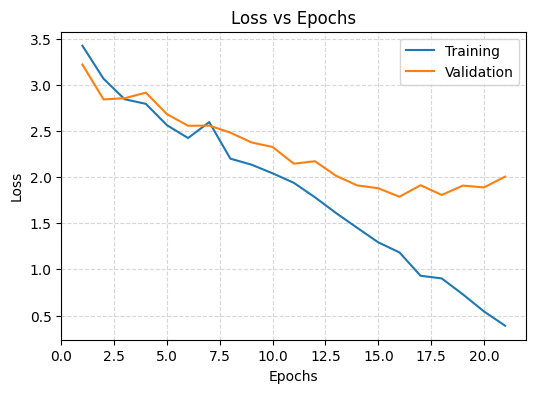

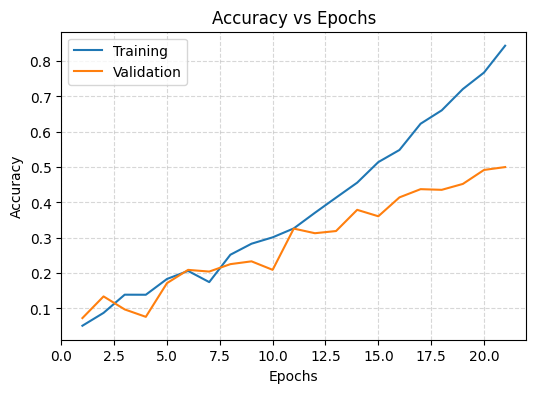

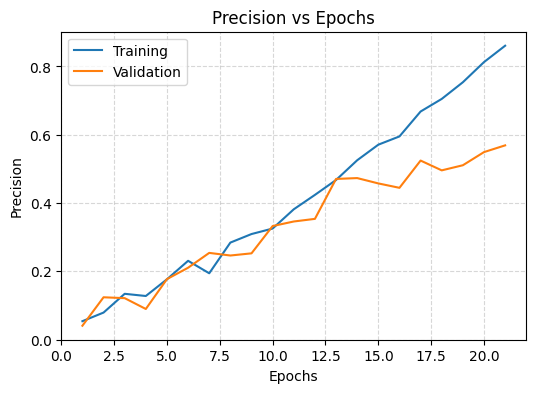

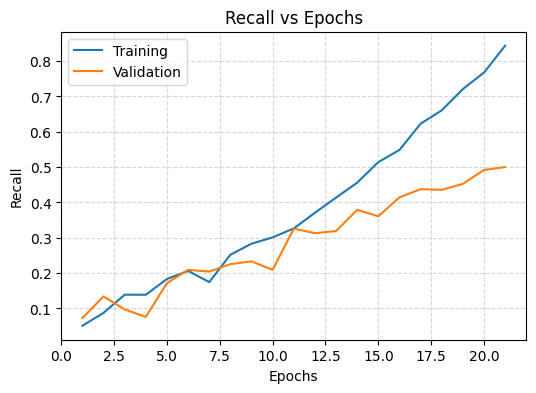

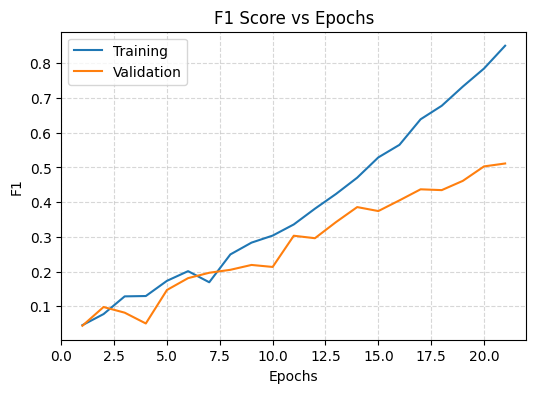

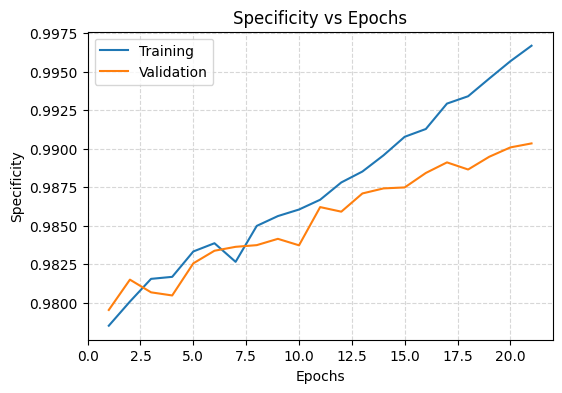

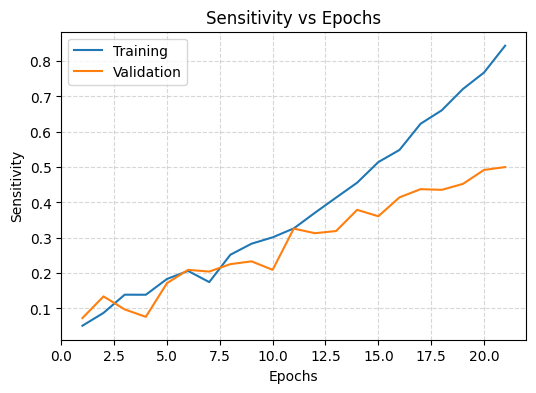

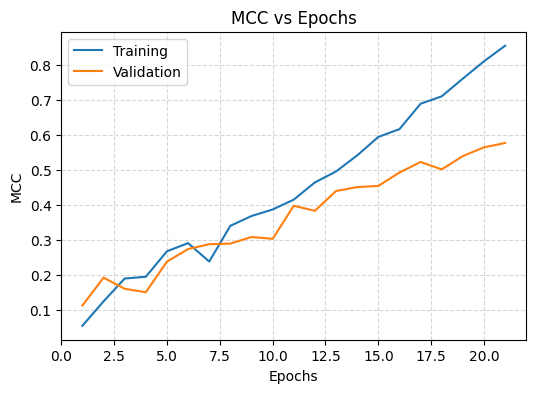

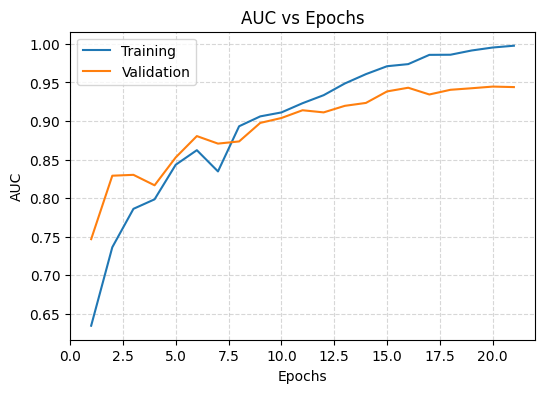

In [31]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")


In [25]:
# Load best model
model.load_state_dict(torch.load("best_vit_44c.pth"))

model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [26]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 56/56 [00:10<00:00,  5.28it/s]


===== TEST RESULTS =====
Test Loss: 1.8686
ACC: 0.4105
PRECISION: 0.5189
RECALL: 0.4105
F1: 0.4144
AUC: 0.9367
MCC: 0.4923


In [27]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.4255    0.5714    0.4878        35
           1     0.4906    0.5652    0.5253        46
           2     0.3571    0.1471    0.2083        34
           3     1.0000    0.7692    0.8696        13
           4     0.7037    0.8636    0.7755        22
           5     0.6429    0.6000    0.6207        15
           6     0.1667    0.4444    0.2424         9
           7     0.3000    0.6000    0.4000        10
           8     1.0000    0.0909    0.1667        11
           9     0.0000    0.0000    0.0000         4
          10     0.0000    0.0000    0.0000         3
          11     0.0000    0.0000    0.0000         5
          12     1.0000    0.6000    0.7500         5
          13     1.0000    0.1250    0.2222         8
          14     0.1667    0.1429    0.1538         7
          15     0.5000    0.2727    0.3529        11
          16     0.5238    0.5789    0.5500  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


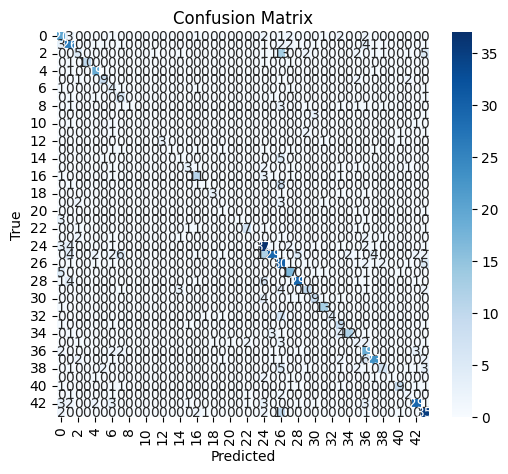

In [28]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [29]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


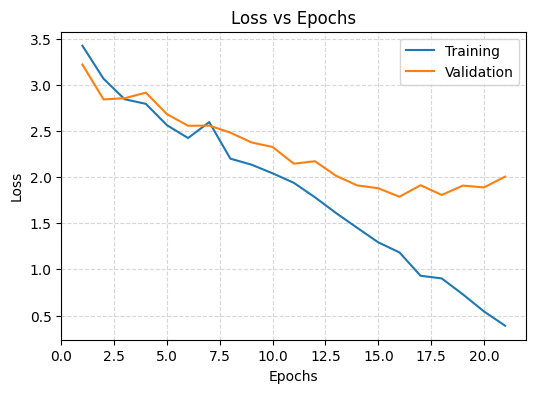

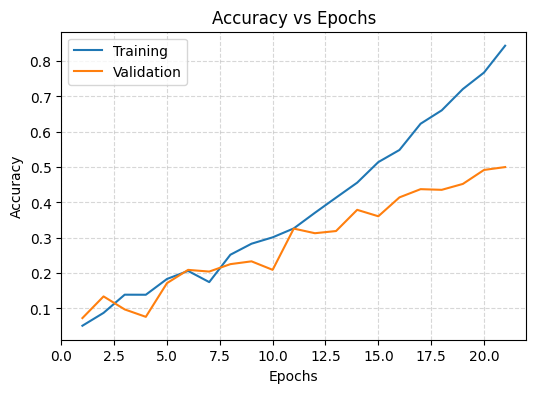

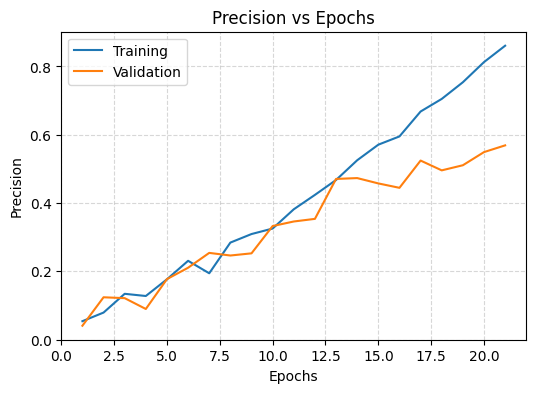

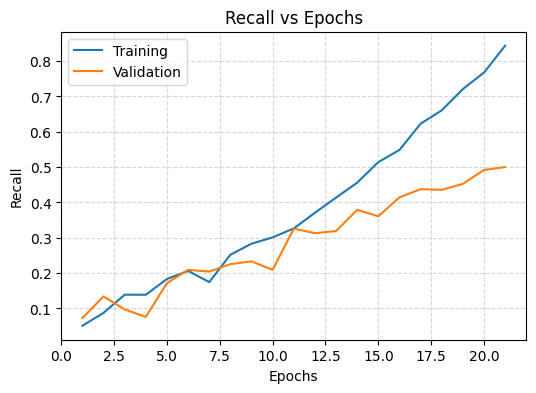

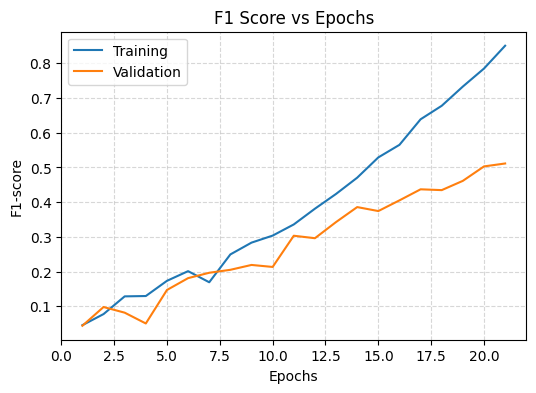

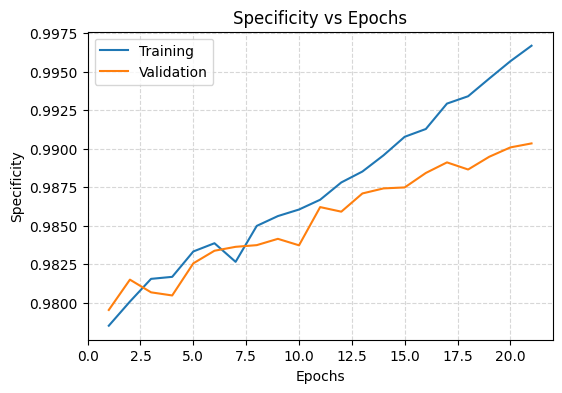

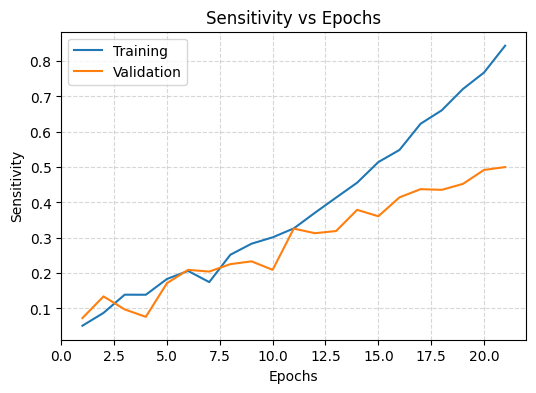

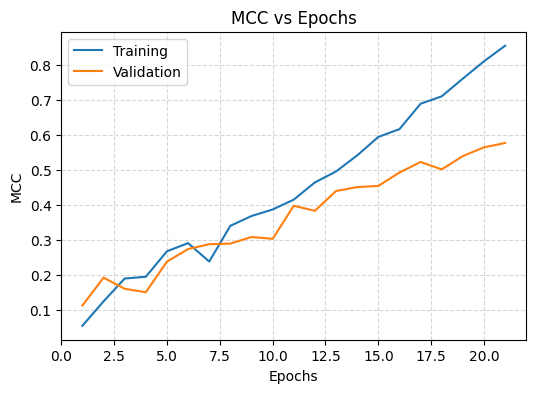

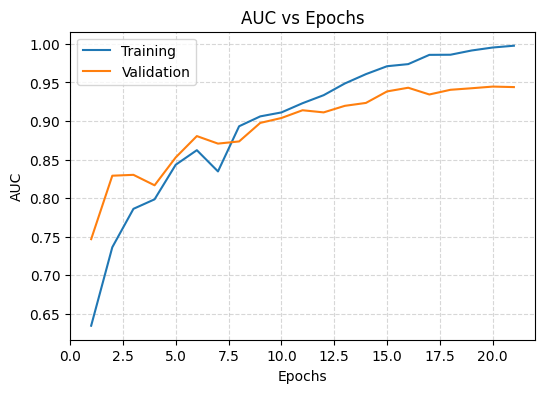

In [30]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
